# Detección de enfermedad cardiaca mediante Electrocardiograma.

El conjunto de datos PTB-XL es una colección extensa de electrocardiogramas (ECG) publicada por PhysioNet. Contiene registros de 12 derivaciones de ECG con una frecuencia de muestreo de 500 Hz, recopilados de pacientes en hospitales alemanes. Se puede encontrar en el enlace https://physionet.org/content/ptb-xl/1.0.3/ y su objetivo es facilitar la investigación en el análisis automatizado de señales cardíacas, incluyendo la detección de enfermedades cardíacas mediante técnicas de aprendizaje automático y ciencia de datos.

**Descripción del conjunto de datos** 

- **Cantidad de registros:** 21,837 electrocardiogramas.
- **Frecuencia de muestreo:** 500 Hz.
- **Duración:** Cada registro tiene aproximadamente 10 segundos de señal.
- **Derivaciones:** 12 canales estándar de ECG (I, II, III, aVR, aVL, aVF, V1-V6).
- **Etiquetas diagnósticas:**
    - **Superdiagnósticos** (5 categorías: normal, isquémico, arritmia, otras anomalías y cambios de conducción).
    - **Diagnósticos detallados** basados en la clasificación de la Sociedad Europea de Cardiología.
    - **Etiquetas de ritmo.**

Además de las señales de ECG, el conjunto de datos incluye información demográfica de los pacientes, como edad y sexo, lo que permite enriquecer el análisis y desarrollar modelos más robustos.

Debido a su tamaño y riqueza de información, PTB-XL se ha convertido en un estándar para la investigación en inteligencia artificial aplicada a la cardiología, permitiendo la exploración de modelos de clasificación, detección de anomalías y generación de representaciones eficientes de señales fisiológicas.

Este proyecto tiene como objetivo utilizar el conjunto de datos PTB-XL para desarrollar varios **modelos supervisados de clasificación binaria**, diferenciando entre electrocardiogramas normales y anormales, integrando información de señales de ECG y características clínicas de los pacientes. El mejor modelo será elegido bajo la métrica del AUC-ROC.

# Preprocesamiento 

Para alcanzar nuestro objetivo, nos enfocamos únicamente en la etiqueta de diagnóstico NOT NORM, que indica si un paciente presenta una anomalía cardíaca o si su ECG es normal. Esto nos proporciona un subconjunto del dataset original con 15,285 electrocardiogramas.

Nuestro análisis parte de la tabla ecg_dataset.csv, que contiene información de los pacientes junto con sus electrocardiogramas. En particular, la columna filename_hr referencia el archivo correspondiente a cada ECG.

El propósito de esta sección es construir una tabla apta para nuestros modelos de aprendizaje supervisado, asegurando que los datos sean numéricos, completos y limpios. A esta tabla la denominamos TAD (Tabla Analítica de Datos). Para generarla, realizamos un análisis exploratorio de datos sobre ecg_dataset.csv y aplicamos una transformación de las variables categóricas a valores numéricos mediante WoE & IV.

Finalmente, combinamos esta tabla con las características extraídas de los electrocardiogramas, calculando la media y desviación estándar en bloques de 500 muestras para cada una de las 12 derivaciones y aplicando una transformada de fourier. Esto nos permite capturar patrones relevantes en las señales de ECG y enriquecer la representación de los datos para el modelo.


In [1]:
# Data wrangling
import pandas as pd
import numpy as np
#Graficas
import graficadores as gf
#import matplotlib.pyplot as plt
import cufflinks as cf
import plotly.offline as pyo
# Imputación de valores faltantes
from sklearn.impute import SimpleImputer
from scipy.stats import ks_2samp
# Outliers
from sklearn.ensemble import IsolationForest
# Manipulación del formato Wave Form DataBase
import wfdb
# Manejo de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
cf.go_offline()
pyo.init_notebook_mode(connected=True)

## Carga de datos

In [2]:
df = pd.read_csv('./data/ecg_dataset.csv')
df

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,filename_hr,NOT_NORM
0,16286,10874.0,68.0,0,NaN,NaN,0.0,0.0,CS100 3,1996-07-04 14:12:49,records500/16000/16286_hr,1
1,2647,20573.0,34.0,1,NaN,57.0,0.0,0.0,CS-12 E,1989-04-09 08:52:33,records500/02000/02647_hr,0
2,11732,12198.0,53.0,0,NaN,81.0,0.0,0.0,CS-12 E,1994-01-26 13:21:53,records500/11000/11732_hr,0
3,19751,20578.0,59.0,0,NaN,NaN,0.0,0.0,CS100 3,1998-10-08 15:19:32,records500/19000/19751_hr,1
4,7898,5104.0,69.0,1,160.0,59.0,6.0,1.0,AT-6 C 5.8,1992-03-22 19:11:05,records500/07000/07898_hr,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15280,15377,16237.0,47.0,0,NaN,71.0,0.0,0.0,CS-12 E,1995-11-25 10:18:13,records500/15000/15377_hr,0
15281,5475,17361.0,47.0,0,NaN,NaN,0.0,0.0,CS100 3,1990-12-06 09:29:17,records500/05000/05475_hr,0
15282,3790,13456.0,75.0,1,NaN,NaN,NaN,3.0,AT-6 C,1990-02-20 14:48:42,records500/03000/03790_hr,1
15283,21643,16888.0,72.0,1,NaN,NaN,0.0,0.0,CS100 3,2000-12-11 11:51:56,records500/21000/21643_hr,1


# Análisis Exploratorio de Datos

## Verificación de tipos de dato

In [3]:
for col in df.columns:
    print(f'{col} -> {df[col].map(type).unique().tolist()}')

ecg_id -> [<class 'int'>]
patient_id -> [<class 'float'>]
age -> [<class 'float'>]
sex -> [<class 'int'>]
height -> [<class 'float'>]
weight -> [<class 'float'>]
nurse -> [<class 'float'>]
site -> [<class 'float'>]
device -> [<class 'str'>]
recording_date -> [<class 'str'>]
filename_hr -> [<class 'str'>]
NOT_NORM -> [<class 'int'>]


In [4]:
df.dtypes

ecg_id              int64
patient_id        float64
age               float64
sex                 int64
height            float64
weight            float64
nurse             float64
site              float64
device             object
recording_date     object
filename_hr        object
NOT_NORM            int64
dtype: object

## Velores nulos

In [5]:
( df.isna().sum() / df.shape[0]) * 100

ecg_id             0.000000
patient_id         0.000000
age                0.399084
sex                0.000000
height            68.276088
weight            56.905463
nurse              6.738633
site               0.098135
device             0.000000
recording_date     0.000000
filename_hr        0.000000
NOT_NORM           0.000000
dtype: float64

Eliminamos columnas con alto porcentaje de nulos

In [6]:
df.drop(columns = ['height', 'weight'], inplace = True) 

Como podemos observar en la siguiente tabla, nuestra muestra o conjunto de datos está balanceado, teniendo aproximadamente la mitad de observaciones como no normal

In [7]:
pd.DataFrame(df["NOT_NORM"].value_counts(1))

,proportion
NOT_NORM,
1,0.582728
0,0.417272


## Separación de Variables

In [8]:
discretas = ['sex','nurse','site','device']
continuas = ['age']
target = 'NOT_NORM'

## Histograma de la edad

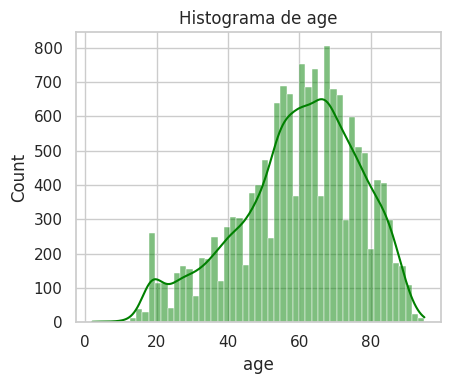

In [9]:
gf.plot_histograms(df,['age'],'hist')

In [10]:
gf.freq_discrete(df,['sex','nurse','device'])

Variable: sex


,Frecuencia absoluta,Frecuencia relativa,Frecuencia acumulada,Frecuencia relativa acumulada
sex,,,,
0,"7,986",52.25%,"7,986",52.25%
1,"7,299",47.75%,"15,285",100.00%


Variable: nurse


,Frecuencia absoluta,Frecuencia relativa,Frecuencia acumulada,Frecuencia relativa acumulada
nurse,,,,
0.0,"5,854",38.30%,"5,854",38.30%
1.0,"3,984",26.06%,"9,838",64.36%
NaN,"1,030",6.74%,"10,868",71.10%
6.0,465,3.04%,"11,333",74.14%
2.0,460,3.01%,"11,793",77.15%
9.0,457,2.99%,"12,250",80.14%
8.0,445,2.91%,"12,695",83.06%
5.0,439,2.87%,"13,134",85.93%
3.0,436,2.85%,"13,570",88.78%


Variable: device


,Frecuencia absoluta,Frecuencia relativa,Frecuencia acumulada,Frecuencia relativa acumulada
device,,,,
CS100 3,"4,344",28.42%,"4,344",28.42%
CS-12,"2,814",18.41%,"7,158",46.83%
AT-6 C 5.5,"2,758",18.04%,"9,916",64.87%
CS-12 E,"2,031",13.29%,"11,947",78.16%
AT-6 6,"1,572",10.28%,"13,519",88.45%
AT-60 3,684,4.47%,"14,203",92.92%
AT-6 C 5.8,571,3.74%,"14,774",96.66%
AT-6 C,371,2.43%,"15,145",99.08%
AT-6 C 5.0,53,0.35%,"15,198",99.43%


Imputamos sobre age, nurse y site

## Imputación de Valores Faltantes

In [11]:
age_original = df['age'].dropna()

In [12]:
# Variables numéricas
imp_numericas = SimpleImputer(strategy = 'mean')
df[['age', 'nurse']] = imp_numericas.fit_transform(df[['age', 'nurse']])
# Variables categóricas
imp_discretas = SimpleImputer(strategy = 'most_frequent')
df[['site']] = imp_discretas.fit_transform(df[['site']])

Sobre age y site se alteró menos del 1 % de valores, por lo que no hay diferencia significativa entre la distribución
original e imputada.

Se hace una prueba KS para ver si nurse tiene una distribución alterada

In [13]:
statistic, p_value = ks_2samp(age_original, df['age'])
print(f'Estadístico KS: {statistic}, Valor p: {p_value}')
if p_value > 0.05:
    print("No se encontraron diferencias significativas en la distribución.")
else:
    print("Se encontraron diferencias significativas en la distribución.")

Estadístico KS: 0.0022025120537773057, Valor p: 0.9999999999999194
No se encontraron diferencias significativas en la distribución.


In [14]:
df.isna().sum()

ecg_id            0
patient_id        0
age               0
sex               0
nurse             0
site              0
device            0
recording_date    0
filename_hr       0
NOT_NORM          0
dtype: int64

##  Mapeo de Categorías con WoE & IV

Utilizamos la transformación entrópica Weight Of Evidence & Information Value para hacer un **mapeo
de las variables categóricas** [ ' sex ' , ' nurse ' , ' site ' , ' device ' ] a **valores numéricos** y así tener valores listos para ser tomados por nuestros modelos de aprendizaje supervisado.

In [15]:
def IV(df, var, tgt):
    aux = df[[var, tgt]].groupby(var).agg(["count", "sum"])
    aux["evento"] = aux[tgt, "sum"]
    aux["no_evento"] = aux[tgt, "count"] - aux[tgt, "sum"]
    aux["%evento"] = aux["evento"] / aux["evento"].sum()
    aux["%no_evento"] = aux["no_evento"] / aux["no_evento"].sum()
    aux["WOE"] = np.log(aux["%no_evento"] / aux["%evento"])
    aux["IV"] = (aux["%no_evento"] - aux["%evento"])*aux["WOE"]
    return aux["IV"].sum()

In [16]:
def WOE(df, var, tgt):
    aux = df[[var, tgt]].groupby(var).agg(["count", "sum"])
    aux["evento"] = aux[tgt, "sum"]
    aux["no_evento"] = aux[tgt, "count"] - aux[tgt, "sum"]
    aux["%evento"] = aux["evento"] / aux["evento"].sum()
    aux["%no_evento"] = aux["no_evento"] / aux["no_evento"].sum()
    aux["WOE"] = np.log(aux["%no_evento"] / aux["%evento"])
    display(aux)
    aux.columns = aux.columns.droplevel(1)
    aux = aux[["WOE"]].reset_index().rename(columns={"WOE": f"W_{var}"})
    df = df.merge(aux, on = var, how = "left")
    return df

In [17]:
for n_bins in range(2, 11):
    for var in continuas:
        df[f"C_{var}"] = pd.qcut(df[var], q=n_bins, duplicates="drop").cat.add_categories(["Missing"]).fillna("Missing").astype(str)
    ls_discretized = [x for x in df.columns if x.startswith("C_")]
    df_iv = pd.DataFrame(columns=["iv"])
    for var in ls_discretized:
        df_iv.loc[var, "iv"] = IV(df = df, var = var, tgt = target)
    print(f"{n_bins} bins")
    display(df_iv)

2 bins


,iv
C_age,0.36348


3 bins


,iv
C_age,0.516272


4 bins


,iv
C_age,0.55979


5 bins


,iv
C_age,0.590132


6 bins


,iv
C_age,0.608349


7 bins


,iv
C_age,0.627908


8 bins


,iv
C_age,0.629324


9 bins


,iv
C_age,0.620138


10 bins


,iv
C_age,0.623133


Como podemos observar, el valor máximo del Information Value se obtiene al hacer 10 cortes

In [18]:
for var in continuas:
    df[f"C_{var}"] = pd.qcut(df[var], q=10, duplicates="drop").cat.add_categories(["Missing"]).fillna("Missing")

In [19]:
df_iv = pd.DataFrame(columns=["iv"])
for var in ls_discretized+discretas:
    df_iv.loc[var, "iv"] = IV(df = df, var = var, tgt = target)

Observamos el poder predictivo de las variables

In [20]:
df_iv.sort_values(by="iv", ascending=False)

,iv
site,inf
C_age,0.623133
device,0.415239
nurse,0.088372
sex,0.053151


Seleccionamos aquellas variables con un IV significativo

In [21]:
ls_best = df_iv[df_iv["iv"]>0.0].index.tolist()

## Weight of Evidence

In [22]:
for var in ls_best:
    df = WOE(df = df, var = var, tgt = target)

NOT_NORM       evento no_evento   %evento %no_evento       WOE
                 count   sum                                                
C_age                                                                       
(1.999, 35.0]     1537   357    357      1180  0.040081   0.185011  1.529517
(35.0, 46.0]      1605   526    526      1079  0.059055   0.169175  1.052472
(46.0, 53.0]      1584   706    706       878  0.079264   0.137661  0.552014
(53.0, 57.0]      1413   797    797       616  0.089480   0.096582  0.076375
(57.0, 62.0]      1844  1168   1168       676  0.131133   0.105989 -0.212872
(62.0, 66.0]      1444   940    940       504  0.105535   0.079022 -0.289321
(66.0, 70.0]      1485  1028   1028       457  0.115415   0.071653 -0.476704
(70.0, 75.0]      1558  1135   1135       423  0.127428   0.066322 -0.653033
(75.0, 81.0]      1451  1114   1114       337  0.125070   0.052838 -0.861647
(81.0, 95.0]      1364  1136   1136       228  0.127540   0.035748 -1.271940
Missing              0     0      0         0  0.000000   0.000000       NaN

NOT_NORM       evento no_evento  %evento %no_evento       WOE
       count   sum                                               
sex                                                              
0       7986  5081   5081      2905  0.57045   0.455472 -0.225092
1       7299  3826   3826      3473  0.42955   0.544528  0.237182

NOT_NORM       evento no_evento   %evento %no_evento       WOE
             count   sum                                                
nurse                                                                   
0.000000      5854  3509   3509      2345  0.393960   0.367670 -0.069063
1.000000      3984  2403   2403      1581  0.269788   0.247883 -0.084677
2.000000       460    95     95       365  0.010666   0.057228  1.680003
2.289933      1030   659    659       371  0.073987   0.058169 -0.240539
3.000000       436   259    259       177  0.029078   0.027752 -0.046695
4.000000       418   249    249       169  0.027956   0.026497 -0.053571
5.000000       439   246    246       193  0.027619   0.030260  0.091342
6.000000       465   253    253       212  0.028405   0.033239  0.157180
7.000000       433   248    248       185  0.027843   0.029006  0.040910
8.000000       445   241    241       204  0.027057   0.031985  0.167306
9.000000       457   252    252       205  0.028292   0.032142  0.127564
10.000000      434   250    250       184  0.028068   0.028849  0.027458
11.000000      430   243    243       187  0.027282   0.029320  0.072030

NOT_NORM       evento no_evento   %evento %no_evento       WOE
        count   sum                                                
site                                                               
0.0      6333  3612   3612      2721  0.405524   0.426623  0.050721
1.0      4386  2481   2481      1905  0.278545   0.298683  0.069803
2.0      3537  2158   2158      1379  0.242281   0.216212 -0.113840
3.0       418   308    308       110  0.034580   0.017247 -0.695637
4.0        71    47     47        24  0.005277   0.003763 -0.338111
5.0        44    31     31        13  0.003480   0.002038 -0.535055
6.0        29    17     17        12  0.001909   0.001881 -0.014324
7.0        31    16     16        15  0.001796   0.002352  0.269444
8.0        25    13     13        12  0.001460   0.001881  0.253940
9.0        24    15     15         9  0.001684   0.001411 -0.176843
10.0       27    17     17        10  0.001909   0.001568 -0.196645
11.0       22    11     11        11  0.001235   0.001725  0.333983
12.0       17    13     13         4  0.001460   0.000627 -0.844672
13.0       14     5      5         9  0.000561   0.001411  0.921770
14.0       23    16     16         7  0.001796   0.001098 -0.492696
15.0       18     9      9         9  0.001010   0.001411  0.333983
16.0       13     7      7         6  0.000786   0.000941  0.179832
17.0       13     9      9         4  0.001010   0.000627 -0.476947
18.0       12     4      4         8  0.000449   0.001254  1.027130
19.0       11     9      9         2  0.001010   0.000314 -1.170094
20.0        6     4      4         2  0.000449   0.000314 -0.359164
21.0       14     6      6         8  0.000674   0.001254  0.621665
22.0        9     2      2         7  0.000225   0.001098  1.586746
23.0       11     7      7         4  0.000786   0.000627 -0.225633
24.0        7     5      5         2  0.000561   0.000314 -0.582308
25.0        7     5      5         2  0.000561   0.000314 -0.582308
26.0        9     8      8         1  0.000898   0.000157 -1.745459
27.0       11     5      5         6  0.000561   0.000941  0.516304
28.0       11     5      5         6  0.000561   0.000941  0.516304
29.0       13     4      4         9  0.000449   0.001411  1.144913
30.0       10     5      5         5  0.000561   0.000784  0.333983
31.0        5     4      4         1  0.000449   0.000157 -1.052311
32.0       11     7      7         4  0.000786   0.000627 -0.225633
33.0        7     3      3         4  0.000337   0.000627  0.621665
34.0        8     5      5         3  0.000561   0.000470 -0.176843
35.0        7     4      4         3  0.000449   0.000470  0.046301
36.0        8     2      2         6  0.000225   0.000941  1.432595
37.0        8     4      4         4  0.000449   0.000627  0.333983
38.0        6     4      4         2  0.000449   0.000314 -0.359164
39.0        5     4      4         1  0.000449   0.000157 -1.052311
40.0        7     4      4         3  0.000449   0.000470  0.046301
41.0        7     2      2         5  0.000225   0.000784  1.250274
42.0        5     3      3         2  0.000337   0.000314 -0.071482
43.0        3     0      0         3  0.000000   0.000470       inf
44.0        3     1      1         2  0.000112   0.000314  1.027130
45.0        6     3      3         3  0.000337   0.000470  0.333983
46.0        2     0      0         2  0.000000   0.000314       inf
47.0        4     1      1         3  0.000112   0.000470  1.432595
48.0        4     1      1         3  0.000112   0.000470  1.432595
49.0        2     1      1         1  0.000112   0.000157  0.333983
50.0        1     0      0         1  0.000000   0.000157       inf

NOT_NORM       evento no_evento   %evento %no_evento       WOE
              count   sum                                                
device                                                                   
AT-6     6     1572   900    900       672  0.101044   0.105362  0.041846
AT-6 C          371   282    282        89  0.031660   0.013954 -0.819288
AT-6 C 5.0       53    40     40        13  0.004491   0.002038 -0.789947
AT-6 C 5.3       49    25     25        24  0.002807   0.003763  0.293161
AT-6 C 5.5     2758  1520   1520      1238  0.170652   0.194105  0.128770
AT-6 C 5.6       38    18     18        20  0.002021   0.003136  0.439343
AT-6 C 5.8      571   350    350       221  0.039295   0.034650 -0.125788
AT-60    3      684   391    391       293  0.043898   0.045939  0.045448
CS-12          2814  1744   1744      1070  0.195801   0.167764 -0.154540
CS-12   E      2031   483    483      1548  0.054227   0.242709  1.498685
CS100    3     4344  3154   3154      1190  0.354104   0.186579 -0.640735

In [23]:
ls_woe = [col for col in df.columns if col.startswith("W_")]
ls_woe

['W_C_age', 'W_sex', 'W_nurse', 'W_site', 'W_device']

## Tabla de valores mapeados

Creamos la tabla X que contiene los valores mapeados de nuestro dataframe inicial, ahora sólo tenemos valores numéricos para **age, sex, nurse, site y device**

In [24]:
X = df[ls_woe].copy()
X['y'] = df['NOT_NORM'].copy()

In [25]:
X['ecg_id'] = df['ecg_id'].copy()

In [26]:
X['W_site'].replace([np.inf, -np.inf], np.nan, inplace=True)
mediana = X['W_site'].median()
X['W_site'].fillna(mediana, inplace=True)

In [27]:
X.head()

,W_C_age,W_sex,W_nurse,W_site,W_device,y,ecg_id
0,-0.476704,-0.225092,-0.069063,0.050721,-0.640735,1,16286
1,1.529517,0.237182,-0.069063,0.050721,1.498685,0,2647
2,0.552014,-0.225092,-0.069063,0.050721,1.498685,0,11732
3,-0.212872,-0.225092,-0.069063,0.050721,-0.640735,1,19751
4,-0.476704,0.237182,0.157180,0.069803,-0.125788,0,7898


## Ingeniería de Variables Sobre cada Electrocardioagrama (ECG)

La columna **filename_hr** contiene direcciones de archivos. Cada uno de estos archivos es la lectura durante 10 segundos de un electrocardiograma en un formato comprimido. 

In [28]:
df[['ecg_id','filename_hr','NOT_NORM']].head()

,ecg_id,filename_hr,NOT_NORM
0,16286,records500/16000/16286_hr,1
1,2647,records500/02000/02647_hr,0
2,11732,records500/11000/11732_hr,0
3,19751,records500/19000/19751_hr,1
4,7898,records500/07000/07898_hr,0


Ahora exploremos los archivos de electrocardiogramas, así se vería el primero de ellos;

In [29]:
record_1 = wfdb.rdsamp('records500/16000/16286_hr')

In [30]:
record_1

(array([[ 0.025, -0.025, -0.05 , ..., -0.23 , -0.01 , -0.005],
        [ 0.025, -0.025, -0.05 , ..., -0.23 , -0.01 , -0.005],
        [ 0.025, -0.025, -0.05 , ..., -0.231, -0.01 , -0.005],
        ...,
        [-0.04 , -0.02 ,  0.02 , ...,  0.025, -0.01 , -0.025],
        [-0.04 , -0.02 ,  0.02 , ...,  0.025, -0.01 , -0.025],
        [-0.04 , -0.02 ,  0.02 , ...,  0.025, -0.01 , -0.025]]),
 {'fs': 500,
  'sig_len': 5000,
  'n_sig': 12,
  'base_date': None,
  'base_time': None,
  'units': ['mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV'],
  'sig_name': ['I',
   'II',
   'III',
   'AVR',
   'AVL',
   'AVF',
   'V1',
   'V2',
   'V3',
   'V4',
   'V5',
   'V6'],
  'comments': []})

In [31]:
record = wfdb.rdrecord("records500/16000/16286_hr")

En la siguiente grafica observamos cada una de las 12 derivaciones del electrocargiograma a lo largo del tiempo.

In [32]:
df_imagen = pd.DataFrame(record.p_signal, columns=record.sig_name)
df_imagen.iplot(title="Señales de ECG", xTitle="Tiempo (muestras)", yTitle="Amplitud")

Vamos a obtener el promedio y desviación estandar de cada 500 registros, esto equivale a las mediciones 
de 1 segundo, ya que la tasa de muestreo es de 500 Hz

In [33]:
media = [f'der_{dev+1}_seg_{seg+1}_fft_media' for dev in range(12) for seg in range(10)]
desv_est = [f'der_{dev+1}_seg_{seg+1}_fft_std' for dev in range(12) for seg in range(10)]
electrocardiograma = pd.DataFrame(columns = media + desv_est)  

In [34]:
for idx, row in df.iterrows():
    
    record = wfdb.rdsamp(row['filename_hr'])
    data = record[0]  # Extrae la matriz de 5000 registros x 12 canales
    
    frecuencia = 500
    segmentos = data.shape[0] // frecuencia
    
    means = []
    std_devs = []
    
    for derivacion in range(data.shape[1]):
        for segment in range(segmentos):
            start = segment * frecuencia
            end = start + frecuencia
            segment_data = data[start:end, derivacion]
            
            # Transformada de Fourier
            fft_segment = np.fft.fft(segment_data)
            
            # Media y desviación estándar
            means.append(np.mean(np.abs(fft_segment)))
            std_devs.append(np.std(np.abs(fft_segment)))
    
    electrocardiograma.loc[idx] = means + std_devs

In [35]:
electrocardiograma

,der_1_seg_1_fft_media,der_1_seg_2_fft_media,der_1_seg_3_fft_media,der_1_seg_4_fft_media,der_1_seg_5_fft_media,der_1_seg_6_fft_media,der_1_seg_7_fft_media,der_1_seg_8_fft_media,der_1_seg_9_fft_media,der_1_seg_10_fft_media,...,der_12_seg_1_fft_std,der_12_seg_2_fft_std,der_12_seg_3_fft_std,der_12_seg_4_fft_std,der_12_seg_5_fft_std,der_12_seg_6_fft_std,der_12_seg_7_fft_std,der_12_seg_8_fft_std,der_12_seg_9_fft_std,der_12_seg_10_fft_std
0,1.476646,1.137670,1.052837,1.986496,1.980522,1.164695,1.128791,1.491348,1.160445,1.206870,...,5.270704,3.929790,3.777307,4.135906,4.109803,3.630042,3.830436,5.282345,3.583558,3.368695
1,0.715700,0.533308,0.863365,0.783816,0.810439,0.798000,0.636286,0.797883,0.905354,0.797751,...,3.400847,1.907335,3.587203,3.687820,3.696344,3.326853,1.925027,3.602505,3.627987,3.758223
2,0.751542,0.744743,0.718097,0.730957,0.717761,0.782675,0.709717,0.656104,0.682761,0.375205,...,3.834868,3.573462,3.569211,3.662488,3.500226,3.513594,3.600067,3.758661,3.717570,2.495752
3,1.489811,1.356284,1.459757,1.436581,1.503599,1.771301,1.463916,1.480711,1.542121,1.443079,...,2.548027,2.441432,2.518861,2.476902,2.520664,3.335534,2.661575,2.532827,2.598910,2.525304
4,1.028991,1.192041,0.629712,1.065211,1.003696,0.973077,1.031767,1.087891,1.098225,1.065778,...,13.332728,3.131690,4.544796,2.670560,3.992905,1.792294,1.876424,2.221627,3.106862,3.359491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15280,0.563758,0.568873,0.582547,0.543070,0.564093,0.563150,0.562715,0.644718,0.603167,0.531713,...,6.460662,7.820084,11.530706,8.504455,2.593219,5.890009,6.468781,4.283926,5.226723,2.600098
15281,1.006199,0.871506,0.748085,0.777819,0.717468,0.845336,0.927591,1.100608,0.841940,0.738727,...,5.348450,3.841426,4.624238,3.864639,3.881883,3.764343,3.758935,5.159382,4.464792,4.242138
15282,1.345652,1.390240,1.804303,2.276219,1.408447,1.431245,1.438135,1.412456,1.757059,1.420925,...,3.900970,3.766219,3.845107,5.152145,4.383191,3.830861,3.700145,4.072904,5.465196,4.738237
15283,3.550677,3.063009,1.707286,1.831779,2.104473,2.265406,2.324372,2.362728,2.337907,2.484626,...,11.052293,9.660376,9.828239,9.793048,9.219899,8.669737,8.386153,8.928521,8.356999,8.155467


## Obteniendo la TAD

In [36]:
TAD = pd.concat([X, electrocardiograma], axis=1)

Ahora hemos conseguido la Tabla Analítica de Datos, que podemos utilizar para entrenar nuestros modelos.

In [37]:
TAD

,W_C_age,W_sex,W_nurse,W_site,W_device,y,ecg_id,der_1_seg_1_fft_media,der_1_seg_2_fft_media,der_1_seg_3_fft_media,...,der_12_seg_1_fft_std,der_12_seg_2_fft_std,der_12_seg_3_fft_std,der_12_seg_4_fft_std,der_12_seg_5_fft_std,der_12_seg_6_fft_std,der_12_seg_7_fft_std,der_12_seg_8_fft_std,der_12_seg_9_fft_std,der_12_seg_10_fft_std
0,-0.476704,-0.225092,-0.069063,0.050721,-0.640735,1,16286,1.476646,1.137670,1.052837,...,5.270704,3.929790,3.777307,4.135906,4.109803,3.630042,3.830436,5.282345,3.583558,3.368695
1,1.529517,0.237182,-0.069063,0.050721,1.498685,0,2647,0.715700,0.533308,0.863365,...,3.400847,1.907335,3.587203,3.687820,3.696344,3.326853,1.925027,3.602505,3.627987,3.758223
2,0.552014,-0.225092,-0.069063,0.050721,1.498685,0,11732,0.751542,0.744743,0.718097,...,3.834868,3.573462,3.569211,3.662488,3.500226,3.513594,3.600067,3.758661,3.717570,2.495752
3,-0.212872,-0.225092,-0.069063,0.050721,-0.640735,1,19751,1.489811,1.356284,1.459757,...,2.548027,2.441432,2.518861,2.476902,2.520664,3.335534,2.661575,2.532827,2.598910,2.525304
4,-0.476704,0.237182,0.157180,0.069803,-0.125788,0,7898,1.028991,1.192041,0.629712,...,13.332728,3.131690,4.544796,2.670560,3.992905,1.792294,1.876424,2.221627,3.106862,3.359491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15280,0.552014,-0.225092,-0.069063,0.050721,1.498685,0,15377,0.563758,0.568873,0.582547,...,6.460662,7.820084,11.530706,8.504455,2.593219,5.890009,6.468781,4.283926,5.226723,2.600098
15281,0.552014,-0.225092,-0.069063,0.050721,-0.640735,0,5475,1.006199,0.871506,0.748085,...,5.348450,3.841426,4.624238,3.864639,3.881883,3.764343,3.758935,5.159382,4.464792,4.242138
15282,-0.653033,0.237182,-0.240539,-0.695637,-0.819288,1,3790,1.345652,1.390240,1.804303,...,3.900970,3.766219,3.845107,5.152145,4.383191,3.830861,3.700145,4.072904,5.465196,4.738237
15283,-0.653033,0.237182,-0.069063,0.050721,-0.640735,1,21643,3.550677,3.063009,1.707286,...,11.052293,9.660376,9.828239,9.793048,9.219899,8.669737,8.386153,8.928521,8.356999,8.155467


In [38]:
TAD.to_csv('./data/TAD_ECG.csv')